In [1]:
from cpp_algorithms import darp, imshow, get_random_coords, get_all_area_maps

In [2]:
import geopandas
import geojson
import json
import sys
import shapely
from shapely.geometry import shape
from haversine import haversine, Unit
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import LineString
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import geopy
import geopy.distance
import pyproj
from shapely.ops import transform
from functools import partial

In [3]:
myshpfile = geopandas.read_file('layers\\POLYGON.shp')
myshpfile.to_file('myJson.geojson', driver='GeoJSON')
with open('myJson.geojson') as f:
    features = json.load(f)["features"] 
maparea = ([shape(feature["geometry"]).buffer(0) for feature in features])

In [4]:
obstacles = np.zeros([3],dtype = 'O')
for x in range(0,3):
    obstacles[x] = maparea[x+1]

In [5]:
# The bounds of the map minx miny maxx maxy
outer_rect = maparea[0].bounds
print(outer_rect)

(72.79214859008789, 18.920089944412993, 72.84896850585938, 19.025283423553358)


In [6]:
def gridpoints(rect,dist):
    height = haversine((rect[1],rect[0]),(rect[3],rect[0]))
    length = haversine((rect[1],rect[0]),(rect[1],rect[2]))
    d = geopy.distance.distance(kilometers = dist)
    horizontalcells = ceil(length/dist)
    verticalcells = ceil(height/dist)
    
    latitudelist = []
    start = geopy.Point(rect[1],rect[0])
    for _ in range(verticalcells):
        latitudelist.append(start)
        final = d.destination(point=start, bearing=0)
        start = final
    latitudelist.append(start)
    
    longitudelist = []
    start = geopy.Point(rect[1],rect[0])
    for _ in range(horizontalcells):
        longitudelist.append(start)
        final = d.destination(point=start, bearing=90)
        start = final
    longitudelist.append(start)
    
    return latitudelist,longitudelist,verticalcells,horizontalcells

In [7]:
latitudelist,longitudelist,vertical,horizontal = gridpoints(outer_rect,0.1) #binding rectangle and distance are sent as parameters

In [8]:
mapboundary = maparea[0]

In [9]:
bounding_rectangle_grid= Polygon([(longitudelist[0][1],latitudelist[0][0]),(longitudelist[horizontal][1],latitudelist[0][0]),(longitudelist[horizontal][1],latitudelist[vertical][0]),(longitudelist[0][1],latitudelist[vertical][0])]) 

In [10]:
outside_map_non_traverse_area = bounding_rectangle_grid.difference(mapboundary) # 

In [11]:
c = np.zeros([vertical,horizontal],dtype = int)
lookup_c = np.zeros([vertical,horizontal],dtype = 'O')

In [12]:
obstacle_partial = {}
for q in range(len(obstacles)):
    obstacle_partial[q] = []

In [13]:
boundary_partial = []

In [14]:
def matrixandlookup(c,lookup_c,outside_map_traverse_area,mapboundary,rect,dist):
    latitudelist,longitudelist,vertical,horizontal = gridpoints(rect,dist)
    for x in range(len(latitudelist)-1):
        for y in range(len(longitudelist)-1):
            square = Polygon([(longitudelist[y][1],latitudelist[vertical-x][0]),(longitudelist[y+1][1],latitudelist[vertical-x][0]),(longitudelist[y+1][1],latitudelist[vertical-x-1][0]),(longitudelist[y][1],latitudelist[vertical-x-1][0])]) 
            lookup_c[x,y] = square.centroid
            # storing value of centre point
            if(outside_map_traverse_area.contains(square)):
                c[x,y] = -1  # region outside the map but inside the gird
            if(square.intersects(mapboundary)):
                    z = square.intersection(mapboundary)
                    if(not z.is_empty):
                        if(mapboundary.contains(z)):
                            c[x,y] = 0 #region inside the map
                        else:
                            c[x,y] = 0 #2 is for boundary partial
                            #boundary_partial.append([x,y])

            for q in range(len(obstacles)):
                if(square.intersects(obstacles[q])):
                    z = square.intersection(obstacles[q])
                    if(not z.is_empty):
                        if(z.within(obstacles[q])):
                            c[x,y] = -1    # inside the obstacle i.e fully covered
                        else:
                            if(not c[x,y] == 2):  
                                c[x,y] = -2 # partially covered obstacle
                                #a = obstacle_partial[q]
                                #a.append([x,y])
                elif(square.contains(obstacles[q])):
                    c[x,y] = -2 # partially covered obstacle


In [15]:
matrixandlookup(c,lookup_c,outside_map_non_traverse_area,mapboundary,outer_rect,0.1) #binding rectangle and distance  are the last 2 parameters

In [16]:
darpmatrix = np.zeros([vertical,horizontal],dtype = int)
np.copyto(darpmatrix,c)

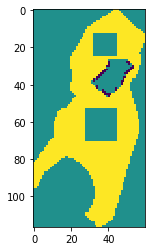

In [17]:
import matplotlib.pyplot as plt
a = plt.imshow(darpmatrix, interpolation = 'nearest')
plt.gca()

In [18]:
darpmatrix[darpmatrix==-2] = -1
darpmatrix[darpmatrix==2] = -1

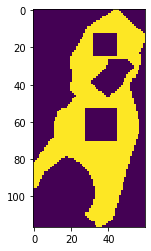

In [19]:
import matplotlib.pyplot as plt
a = plt.imshow(darpmatrix, interpolation = 'nearest')
plt.gca()

In [20]:
start_pts = get_random_coords(darpmatrix,3)

In [21]:
start_pts_1 = [(sub[1], sub[0]) for sub in start_pts]

In [22]:
print(start_pts_1)

[(47, 16), (43, 102), (38, 113)]


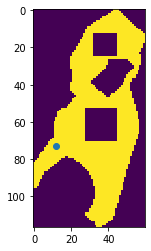

In [23]:
import matplotlib.pyplot as plt
a = plt.imshow(darpmatrix, interpolation = 'nearest')
plt.gca()
plt.scatter(12,73)

In [24]:
A,x = darp(100,darpmatrix,start_pts,pbar=True)

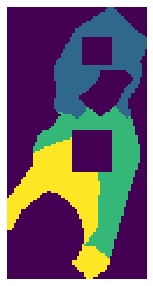

In [25]:
imshow(A)